In [6]:
# sudo service mysql stop
# docker run --name mysql_call -p 3306:3306 -e MYSQL_ROOT_PASSWORD=your_secret_pwd -d mysql:latest

In [76]:
import pymssql
import pymysql
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt

### connection init

In [27]:
# calls
with open('mysql_local.pass','r') as file:
    calls_pass = file.read().replace('\n', '')
    file.close()
calls_conn = pymysql.connect(
            host = '10.2.4.87', 
            user = 'root',
            passwd = calls_pass,
            db = '1c',
            autocommit = True
        )
calls_cursor = calls_conn.cursor()

In [33]:
# transcribations
with open('sql.pass','r') as file:
    trans_pass = file.read().replace('\n', '')
    file.close()            
trans_conn = pymssql.connect(
            server = '10.2.4.124',
            user = 'ICECORP\\1c_sql',
            password = trans_pass,
            database = 'voice_ai',
            #autocommit=True
        )
trans_cursor = trans_conn.cursor()

In [170]:
# mico96 (КЦ)
with open('mysql.pass','r') as file:
    mico_pass = file.read().replace('\n', '')
    file.close()
mico_conn = pymysql.connect(
            host = '10.2.4.146', 
            user = 'asterisk',
            passwd = mico_pass,
            db = 'MICO_96',
            #autocommit = True
        )
mico_cursor = mico_conn.cursor()

In [ ]:
# mrm
with open('mysql.pass','r') as file:
    mico_pass = file.read().replace('\n', '')
    file.close()
mico_conn = pymysql.connect(
            host = '10.2.4.146', 
            user = 'asterisk',
            passwd = mico_pass,
            db = 'MICO_96',
            #autocommit = True
        )
mico_cursor = mico_conn.cursor()

### check mico96

In [166]:
query = "show tables;"
tables = pd.read_sql(query, con = mico_conn)
tables

,Tables_in_MICO_96
0,MRMcdr
1,MRMcel
2,NomeraLOCALHOST
3,PT1C_cdr
4,PT1C_cdr_MICO
5,PT1C_cdr_MICO_2018
6,PT1C_cdr_MICO_RES
7,UserStatusHistory
8,cdr_222
9,cel


In [172]:
query = "SELECT * from PT1C_cdr_MICO where calldate>'2021-04-26' limit 2;"
mico = pd.read_sql(query, con = mico_conn)
mico

,id,calldate,clid,src,dst,dcontext,lastapp,lastdata,duration,billsec,...,amaflags,accountcode,uniqueid,userfield,answer,end,recordingfile,peeraccount,linkedid,sequence
0,13917680,2021-04-26 00:56:14,"""4954444444"" <74953605660>",74953605660,4954444444,incoming,Hangup,,11.2323,11.2291,...,DOCUMENTATION,None,1619387774.3134951,,2021-04-26 00:56:14,2021-04-26 00:56:25,,,1619387774.3134951,3719329
1,13917681,2021-04-26 00:56:56,"""4954444444"" <74953605660>",74953605660,4954444444,incoming,Hangup,,11.1884,11.1863,...,DOCUMENTATION,None,1619387816.3134952,,2021-04-26 00:56:56,2021-04-26 00:57:08,,,1619387816.3134952,3719330


In [241]:
query = "SELECT calldate, src, dst, linkedid, peeraccount"
query += " from PT1C_cdr_MICO where calldate>'2021-04-26 12:05:00'"
#query += " and calldate<'2021-04-26 11:46:00'"
#query += " and peeraccount>'1619426331.30788'"
#query += " and linkedid>'1619426331.3078800'"
#query += " and linkedid<'1619426520.3078906'"
#query += " order by peeraccount limit 50;"
#" and not peeraccount = ''"
#query += " and linkedid ='1619426653.3078971'"
#query += " and peeraccount ='1619426653.3078971'"
#query += " and peeraccount ='1619425635.3078414'"
query += " order by calldate limit 50;"
mico = pd.read_sql(query, con = mico_conn)
mico

,calldate,src,dst,linkedid,peeraccount
0,2021-04-26 12:05:01,5034,1586,1619427901.3144077,
1,2021-04-26 12:05:07,9776079108,s,1619427907.3144085,1619427751.3079685
2,2021-04-26 12:05:07,74956681842,s,1619427907.3144086,
3,2021-04-26 12:05:18,5113,989216546911,1619427918.3144093,
4,2021-04-26 12:05:19,1586,703,1619427767.3143981,
5,2021-04-26 12:05:30,9037253957,s,1619427930.3144100,
6,2021-04-26 12:05:36,989216546911,702,1619427882.3144071,
7,2021-04-26 12:05:37,5113,s,1619427937.3144108,
8,2021-04-26 12:05:37,5118,989260096272,1619427937.3144109,
9,2021-04-26 12:05:52,5119,5000,1619427952.3144127,


In [242]:
# transcribations
query = "SELECT distinct top 50 record_date, src, dst, linkedid, source_id from transcribations"
query += " where record_date>='2021-04-26 12:05:00'"#" and source_id=2"
#query += " and linkedid>'1619426331.3078800'"
#query += " and linkedid<'1619426520.3078906'"
query += " order by record_date;"
#query += " order by linkedid;"
#query += " where record_date>='"+date_from+"' and linkedid = '1619424473.3077800';"
tr = pd.read_sql(query, con = trans_conn)
#tr[tr.linkedid=='1619424473.3077800']
tr

,record_date,src,dst,linkedid,source_id
0,2021-04-26 12:05:06,5155,988312941389,1619427906.3079781,2
1,2021-04-26 12:05:23,4953599988,7059111,1619427923.3079785,2
2,2021-04-26 12:05:24,5118,89853091775,1619427924.3079787,2
3,2021-04-26 12:05:36,5113,89063598193,1619427936.3079791,2
4,2021-04-26 12:05:38,9101802545,89067365901,1619427938.3079799,2
5,2021-04-26 12:05:49,9032539290,89055175824,1619427949.3079813,2
6,2021-04-26 12:05:53,9062409229,989213190002,1619427953.3079817,2
7,2021-04-26 12:05:56,4955151542,5034,1619427955.3144129,1
8,2021-04-26 12:06:06,9160204598,5035,1619427965.3144138,1
9,2021-04-26 12:06:08,79023062272,89049282849,1619427968.3079833,2


### report

In [243]:
# calls
#query = "SELECT cast(call_date as date), ak, miko, mrm, incoming, linkedid, base_name from calls;"
query = "SELECT date(call_date) as call_date, ak, miko, mrm, incoming, linkedid, base_name from calls;"
#query = "SELECT * from calls;"
calls = pd.read_sql(query, con = calls_conn)
date_min = calls.call_date.min()
date_max = calls.call_date.max()
#calls.drop(['id'], axis = 1, inplace = True)
calls

,call_date,ak,miko,mrm,incoming,linkedid,base_name
0,2021-04-22,0,1,0,0,1619065299.3050508,1c_service_region
1,2021-04-22,1,0,1,0,1619065479.22323747,1c_service_region
2,2021-04-22,0,1,0,0,1619067128.3050609,1c_service_region
3,2021-04-22,0,1,0,0,1619067276.3050641,1c_service_region
4,2021-04-22,0,1,0,0,1619067872.3050737,1c_service_region
...,...,...,...,...,...,...,...
38792,2021-04-25,1,0,1,0,1619379621.22436107,1C_Service
38793,2021-04-25,0,1,0,1,1619379850.3134879,1C_Service
38794,2021-04-25,0,1,0,0,1619380738.3134887,1C_Service
38795,2021-04-25,0,1,0,0,1619380764.3134889,1C_Service


In [246]:
date_from = datetime.datetime.strptime(str(date_min), '%Y-%m-%d').strftime('%Y%m%d %H:%M:%S.000')
date_toto = datetime.datetime.strptime(str(date_max), '%Y-%m-%d').strftime('%Y%m%d %H:%M:%S.000')

In [247]:
# transcribations
query = "SELECT distinct cast(record_date as date) as record_date, linkedid from transcribations"
query += " where cast(record_date as date)>='"+date_from+"' and cast(record_date as date)<='"+date_toto+"';"
trans = pd.read_sql(query, con = trans_conn)
trans

,record_date,linkedid
0,2021-04-22,1619064714.3050495
1,2021-04-22,1619064753.3050498
2,2021-04-22,1619064800.3050500
3,2021-04-22,1619065011.3050502
4,2021-04-22,1619065029.3050504
...,...,...
24055,2021-04-25,1619379695.3071697
24056,2021-04-25,1619379850.3134879
24057,2021-04-25,1619380583.3071701
24058,2021-04-25,1619380610.3071703


In [248]:
date_min, date_max

(datetime.date(2021, 4, 22), datetime.date(2021, 4, 25))

In [249]:
len(calls), len(trans)

(38797, 24060)

In [250]:
len(calls.linkedid.unique()), len(trans.linkedid.unique())

(23788, 24060)

In [251]:
df = pd.merge(calls, trans, on='linkedid', how="outer", indicator=True)

In [252]:
len(df[df._merge == 'left_only']), len(df[df._merge == 'both']), len(df[df._merge == 'right_only'])

(30717, 8080, 16109)

In [153]:
df.drop(['ak', 'miko', 'mrm', 'incoming', 'base_name'], axis = 1, inplace = True)

In [154]:
def both(val):
    return 1 if val == 'both' else 0

def left_only(val):
    return 1 if val == 'left_only' else 0

def right_only(val):
    return 1 if val == 'right_only' else 0

In [155]:
df['L'] = df._merge
df['B'] = df._merge
df['R'] = df._merge
df.L.apply(left_only)
df.B.apply(both)
df.R.apply(right_only)

0        0
1        0
2        0
3        0
4        0
        ..
54901    1
54902    1
54903    1
54904    1
54905    1
Name: R, Length: 54906, dtype: int64

In [156]:
#df.groupby(['call_date', 'record_date', '_merge']).count()
#df.groupby(['_merge']).count()
df.groupby(['call_date', 'record_date']).count()

,,linkedid,_merge,L,B,R
call_date,record_date,,,,,
2021-04-22,2021-04-22,2244,2244,2244,2244,2244
2021-04-23,2021-04-23,2144,2144,2144,2144,2144
2021-04-24,2021-04-24,2016,2016,2016,2016,2016
2021-04-25,2021-04-25,1676,1676,1676,1676,1676


In [130]:
df

,call_date,linkedid,record_date,_merge
0,2021-04-22,1619065299.3050508,NaN,left_only
1,2021-04-22,1619065299.3050508,NaN,left_only
2,2021-04-22,1619065299.3050508,NaN,left_only
3,2021-04-22,1619065479.22323747,NaN,left_only
4,2021-04-22,1619067128.3050609,NaN,left_only
...,...,...,...,...
54901,NaN,1619379624.3071695,2021-04-25,right_only
54902,NaN,1619379695.3071697,2021-04-25,right_only
54903,NaN,1619380583.3071701,2021-04-25,right_only
54904,NaN,1619380610.3071703,2021-04-25,right_only


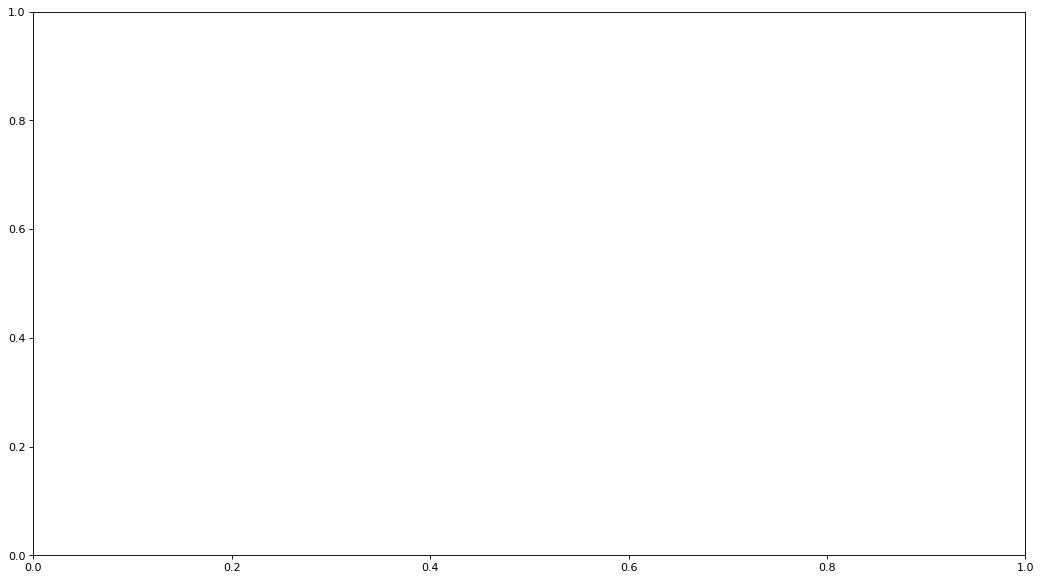

In [86]:
# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

In [87]:
columns

Index(['miko', 'mrm', 'incoming', 'linkedid', 'base_name', '_merge'], dtype='object')

In [81]:
columns

Index(['Sydney', 'NSW', 'Melbourne', 'VIC', 'BrisbaneGC', 'QLD', 'Capitals',
       'Other'],
      dtype='object')

In [85]:
labs

['Sydney', 'NSW', 'Melbourne', 'VIC', 'BrisbaneGC', 'QLD', 'Capitals', 'Other']

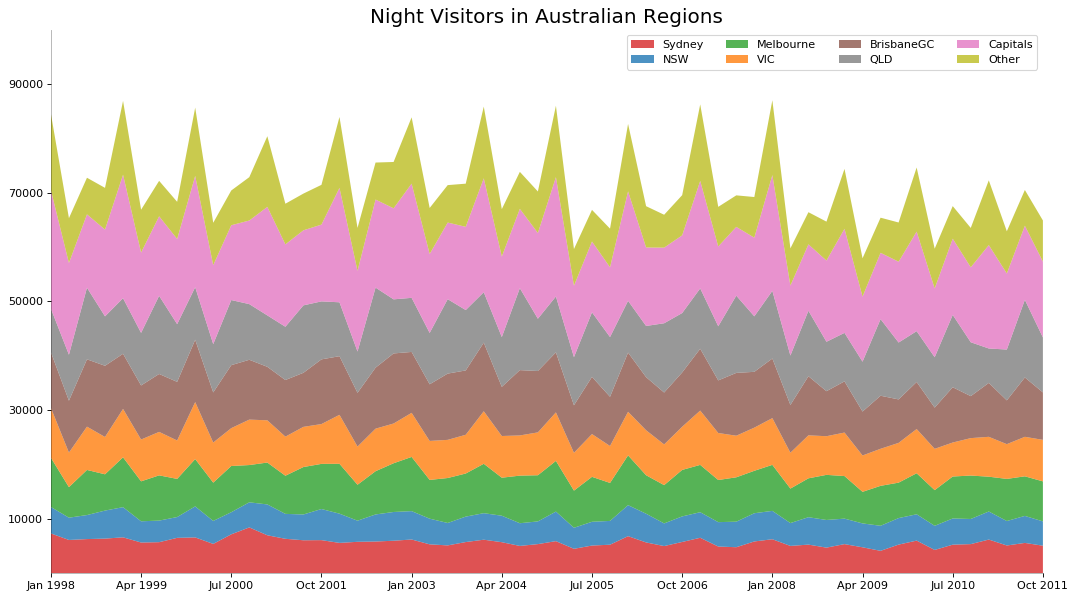

In [80]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/nightvisitors.csv')

# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['yearmon'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y5 = df[columns[5]].values.tolist()
y6 = df[columns[6]].values.tolist()
y7 = df[columns[7]].values.tolist()
y = np.vstack([y0, y2, y4, y6, y7, y5, y1, y3])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Night Visitors in Australian Regions', fontsize=18)
ax.set(ylim=[0, 100000])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::5], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10000, 100000, 20000), fontsize=10)
plt.xlim(x[0], x[-1])

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

### database maintance

In [ ]:
query = "create database 1c;"
cursor.execute(query)

In [ ]:
query = "use 1c;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
query = "show tables;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
#--create table users ( id int not null auto_increment, token varchar(36), 
#email varchar(64), event_date DATETIME, primary key (id) );
query = "create table calls"
query += " ("
query += " id int not null auto_increment,"
query += " call_date DATETIME,"
query += " ak BOOLEAN,"
query += " miko BOOLEAN,"
query += " mrm BOOLEAN,"
query += " incoming BOOLEAN,"
query += " linkedid varchar(64),"
query += " base_name varchar(64),"
query += " primary key (id)"
query += " );"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
query = "drop table calls;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

In [ ]:
query = "delete from calls;"
cursor.execute(query)
for row in cursor.fetchall():
    print(row)

### experiments

In [43]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
columns = pd.read_sql(query, con = trans_conn)
columns

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [ ]:
calls.linkedid = calls.linkedid.str.replace('.WAV','')

In [ ]:
calls[calls.linkedid=='1619120428.22353330.WAV']

In [ ]:
def get_base_name(val):
    return re.findall( r'"(.*?)"', val)[1]

In [ ]:
df.base_name = df.base_name.apply(get_base_name)

In [ ]:
df.base_name = df.base_name.str.replace(r'"(.*?)"', '')

In [ ]:
word = 'Srvr="msk-srv1c01" Ref="1c_service_region"'
re.findall( r'"(.*?)"', word)[1]

In [ ]:
re.findall( r'all (.*?) are', 'all cats are smarter than dogs, all dogs are dumber than cats')
# Output: ['cats', 'dogs']

[x.group() for x in re.finditer( r'all (.*?) are', 'all cats are smarter than dogs, all dogs are dumber than cats')]
# Output: ['all cats are', 'all dogs are']

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='calls';"
calls = pd.read_sql(query, con = conn)
calls

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='calls';"
calls = pd.read_sql(query, con = conn)
calls

In [ ]:
filename = 'data.csv'
dateparser = lambda x: datetime.datetime.strptime(x, "%d.%m.%Y %H:%M:%S")
dtypes = {
        'call_date': 'datetime64',
        'ak': 'bool',
        'miko': 'bool',
         'mrm': 'bool',
         'incoming': 'bool',
         'linkedid': 'str',
         'base_name': 'str',
     }
#df = pd.read_csv(filename, ';', dtype=dtypes, parse_dates = True)
#df = pd.read_csv(filename, ';', parse_dates = True)
df = pd.read_csv(filename, ';', parse_dates = ['call_date'], date_parser=dateparser)
df.call_date.iloc[0], type(df.call_date.iloc[0])

In [ ]:
df.base_name.iloc[0], type(df.base_name.iloc[0])